In [2]:
!unzip 'data.zip'

Archive:  data.zip
  inflating: data/hinglish_stopwords.txt  
   creating: data/test/
  inflating: data/test/Hindi_test_unalbelled_conll_updated.txt  
  inflating: data/test/test_labels_hinglish.txt  
   creating: data/train/
  inflating: data/train/dev_3k_split_conll.txt  
  inflating: data/train/train_14k_split_conll.txt  
  inflating: data/train/train_conll.txt  
  inflating: data/train/trial_conll.txt  


In [3]:
!pip install tensorflow
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.2 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Epoch 1/150
379/379 [==============================] - 3s 5ms/step - loss: 0.9674 - accuracy: 0.5200 - val_loss: 0.8692 - val_accuracy: 0.5913
Epoch 2/150
379/379 [==============================] - 2s 5ms/step - loss: 0.8325 - accuracy: 0.6153 - val_loss: 0.8413 - val_accuracy: 0.6022
Epoch 3/150
379/379 [==============================] - 2s 6ms/step - loss: 0.7911 - accuracy: 0.6417 - val_loss: 0.8409 - val_accuracy: 0.5986
Epoch 4/150
379/379 [==============================] - 2s 5ms/step - loss: 0.7636 - accuracy: 0.6606 - val_loss: 0.8421 - val_accuracy: 0.5983
Epoch 5/150
379/379 [==============================] - 2s 4ms/step - loss: 0.7451 - accuracy: 0.6650 - val_loss: 0.8460 - val_accuracy: 0.6003
Epoch 6/150
379/379 [==============================] - 2s 5ms/step - loss: 0.7281 - accuracy: 0.6746 - val_loss: 0.8546 - val_accuracy: 0.5930
Epoch 7/150
379/379 [==============================] - 1s 4ms/step - loss: 0.7168 - accuracy: 0.6842 - val_loss: 0.8605 - val_accuracy: 0.5923

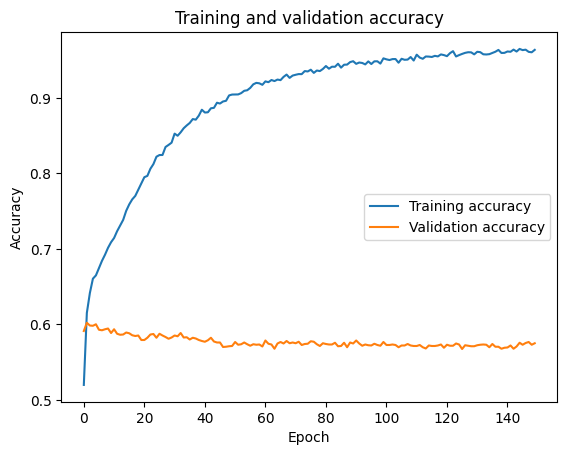

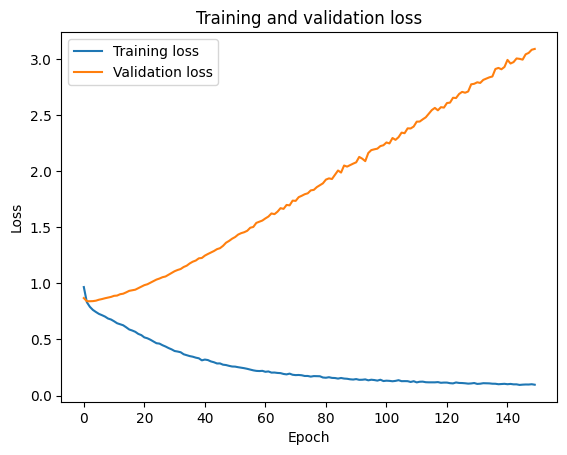

95/95 [==============================] - 0s 2ms/step - loss: 3.0899 - accuracy: 0.5752
Loss:  3.08994722366333
Accuracy:  0.5751569271087646


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

nltk.download('stopwords')

class Tweet:
    def __init__(self):
        self.uid = None
        self.content = ''
        self.sentiment = ''

def cleanTweet(tweet):
    tweet.content = re.sub(r'\_', '', tweet.content)  # remove underscores
    tweet.content = re.sub(r'…', '', tweet.content)  # remove elipses/dots
    tweet.content = re.sub(r'\.', '', tweet.content)  # remove elipses/dots
    tweet.content = re.sub(r'^RT[\s]+', '', tweet.content)  # remove RT
    tweet.content = re.sub(
        "[#@©àâ€¦¥°¤ð¹ÿœ¾¨‡†§‹²¿¸ˆ]", '', tweet.content
    )  # remove weird symbols
    tweet.content = tweet.content.split("http")[0].split('https')[0]  # remove http/https
    tweet.content = ''.join([i for i in tweet.content if not i.isdigit()])  # remove digits
    tweet.content = ''.join([word for word in tweet.content if word not in string.punctuation])  # remove punctuations
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet.content = tokenizer.tokenize(tweet.content)
    tweet.content = ' '.join([i for i in tweet.content])  # convert to string
    return tweet

def load_stop_words():
    stopwords_english = stopwords.words('english')
    stopwords_hinglish = []
    with open('data/hinglish_stopwords.txt', 'r') as fp:
        while True:
            line = fp.readline()
            if not line:
                break
            stopwords_hinglish.append(line.strip())
    return stopwords_english, stopwords_hinglish

def readFile(filename, test_data=False):
    stemmer_english = PorterStemmer()
    stopwords_english, _ = load_stop_words()
    all_tweets = []
    with open(filename, 'r', encoding="utf8") as fp:
        tweet = Tweet()
        last_one = False
        while True:
            line = fp.readline()
            if not line:
                last_one = True
            if len(line.split()) > 1 or last_one:
                if last_one or line.split()[0] == 'meta':
                    if len(tweet.content) > 0 or last_one:
                        all_tweets.append(cleanTweet(tweet))
                        if last_one:
                            break
                        tweet = Tweet()
                    tweet.uid = line.split()[1]
                    tweet.sentiment = line.split()[2] if not test_data else None
                else:
                    if line.split()[1] == "Eng":
                        if line.split()[0] not in stopwords_english:
                            tweet.content += stemmer_english.stem(line.split()[0]) + " "
                    elif line.split()[1] == "Hin":
                        tweet.content += line.split()[0] + " "
                    else:
                        tweet.content += line.split()[0] + " "
    return all_tweets

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Greens):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    classes = ['neutral', 'positive', 'negative']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def show_results(y_test, y_pred):
    print("F1 Score: ", f1_score(y_test, y_pred, average="weighted"))
    print()
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    plot_confusion_matrix(cnf_matrix)

all_tweets = readFile(r'data/train/train_conll.txt')

x_train = [i.content for i in all_tweets]
y_train = [i.sentiment for i in all_tweets]

# Preprocess the data
le = LabelEncoder()
y_train = le.fit_transform(y_train)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# Convert text data to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Convert text data to TF-IDF representations
vectorizer = TfidfVectorizer(max_features=1000)
x_train_tfidf = vectorizer.fit_transform(x_train).toarray()
x_test_tfidf = vectorizer.transform(x_test).toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Build the model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=x_train_tfidf.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_tfidf, y_train_categorical, epochs=150, batch_size=32, validation_data=(x_test_tfidf, y_test_categorical))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(x_test_tfidf, y_test_categorical)
print("Loss: ", loss)
print("Accuracy: ", accuracy)


95/95 [==============================] - 1s 5ms/step
F1 Score:  0.5764916738776038



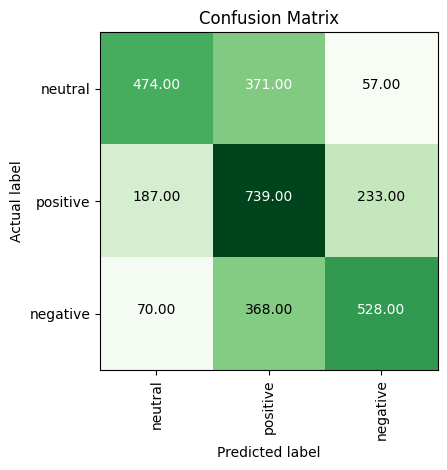

In [6]:
# Perform prediction on the test set
y_pred_probs = model.predict(x_test_tfidf)
y_pred = np.argmax(y_pred_probs, axis=1)

# Display evaluation results
show_results(np.argmax(y_test_categorical, axis=1), y_pred)
